In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from database import Database
from Filter.PB import PB
from Filter.MA import MA
from Filter.Higher_Market import Higher_Market
from Filter.DoubleRateRise import DoubleRateRise
from Filter.Chips import Chips
from Filter.GetFilterData import GetFilterData
from Utils.GetExtraX import GetExtraX
from FeatureSelect.FeatureSelect import FeatureSelect
from FeatureSelect.FeatureXMLGenerate import FeatureXMLGenerate
from Draw.draw import Draw
from Draw.StockDataVisualizer import StockDataVisualizer
import plotly.express as px
import plotly.graph_objects as go
import time

In [2]:
def F_Draw(filtered_data,features,*xml):
    key_list = list(features.keys())
    Draw(filtered_data,key_list,*xml)

In [3]:
def analysis(func_name,start_d,end_d,*xml):

    # 讀取資料
    db = Database()
    # #TODO:一次取完變成data?
    # stock_data = db.get_stock(start_d,end_d).drop('id', axis=1)
    company_data =db.get_company_basic()
    q_data=db.get_finance_report_q()
    m_data=db.get_finance_report_m()
    s_data = db.get_stock(start_d,end_d)
    mk_data = db.get_market_index(start_d,end_d)
    ch_data = db.get_chips(start_d,end_d)

    #選擇策略+防呆
    if func_name == "F_PB":
        selected_companies = PB(q_data)

    elif func_name == "F_DoubleRateRise":
        selected_companies = DoubleRateRise(q_data,start_d)
        
    elif func_name == "F_Chips":
        selected_companies = Chips(ch_data,*xml)

    elif func_name == "F_MA":
        selected_companies = MA(s_data)
        
    elif func_name == "F_Higher_Market":
        selected_companies = Higher_Market(s_data,company_data,mk_data,start_d,end_d)
    else:
        return "請選擇合適篩選標準"
    combine = GetFilterData(company_data,m_data,q_data,s_data,mk_data,ch_data,selected_companies,start_d,end_d)
    filtered_data=combine.getFliterData()

    # with pd.ExcelWriter('filtered_data.xlsx', engine='openpyxl') as writer:
    #     filtered_data.to_excel(writer, index=False, sheet_name='Sheet1')
    
    print(f"符合條件股數:{len(filtered_data)}")

    visualizer = StockDataVisualizer(filtered_data)
    visualizer.get_heat_map_all()
    visualizer.get_industry_pie_all()
    visualizer.get_bar_chart_all()
   
    if xml:
        addX_data = GetExtraX(filtered_data,xml[0])
    else:
        addX_data = filtered_data

    features = FeatureSelect(addX_data)

    FeatureXMLGenerate(features)

    return features, filtered_data
    

c:\Users\iplab\Desktop\論文\Data_Browsing\database.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_from_db.rename(columns=self.column_mapping, inplace=True)
c:\Users\iplab\Desktop\論文\Data_Browsing\database.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_from_db.rename(columns=self.column_mapping, inplace=True)
c:\Users\iplab\Desktop\論文\Data_Browsing\database.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

符合條件股數:229


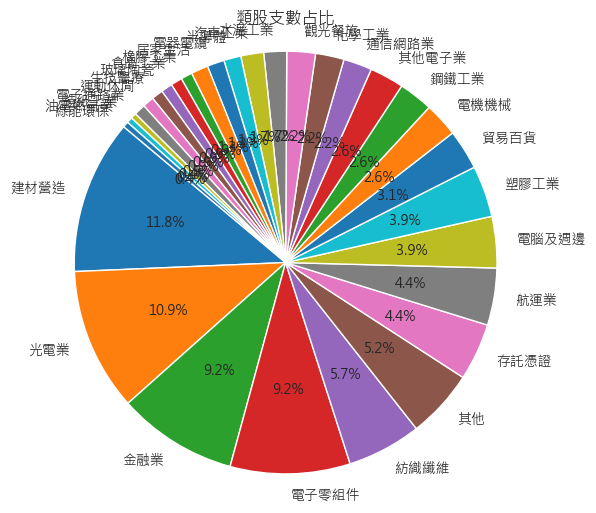

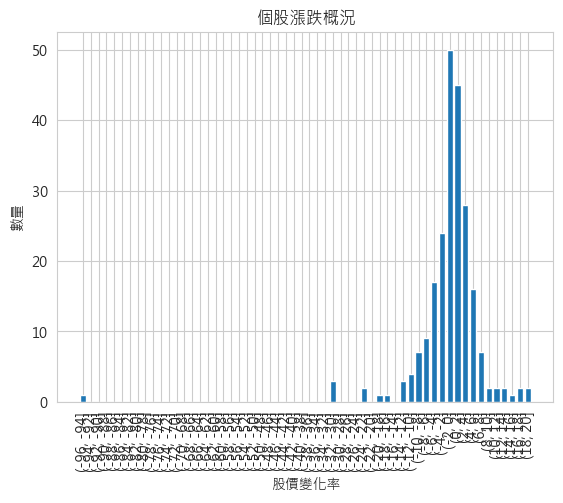

XML_chip1031.xml
{'產業名稱': '類別', '法人買賣超日數': '數值', 'ROA(C)稅前息前折舊前': '數值', '外資買賣超日數': '數值', '季報發布日': '類別'}


c:\Users\iplab\Desktop\論文\Data_Browsing\FeatureSelect\FeatureSelect.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

c:\Users\iplab\Desktop\論文\Data_Browsing\FeatureSelect\FeatureSelect.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

c:\Users\iplab\Desktop\論文\Data_Browsing\FeatureSelect\FeatureSelect.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

In [4]:

features, filtered_data = analysis("F_PB",'2023/03/15','2023/09/15','XML_chip1031.xml')

In [5]:
# F_Draw(filtered_data,features,'v1TestXML1030.xml')

<Figure size 640x480 with 0 Axes>

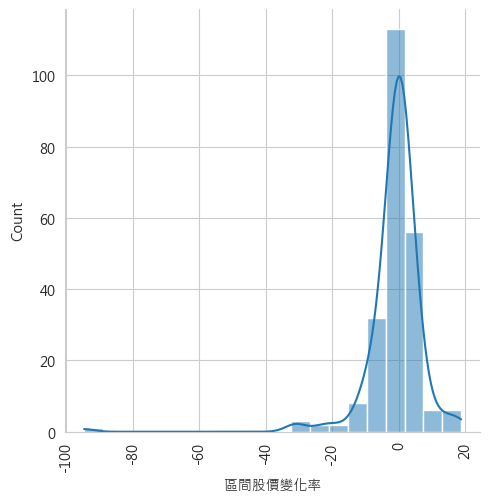

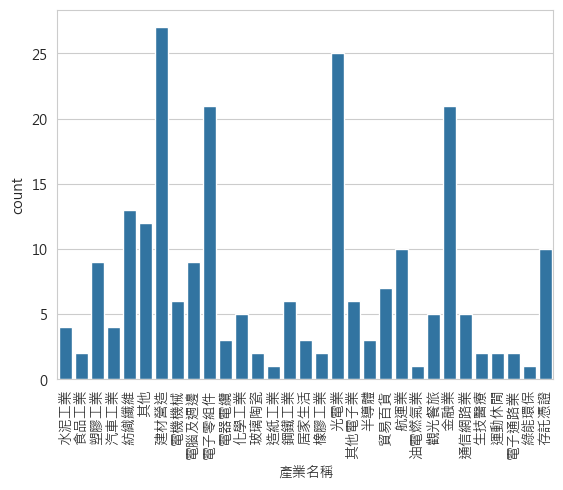

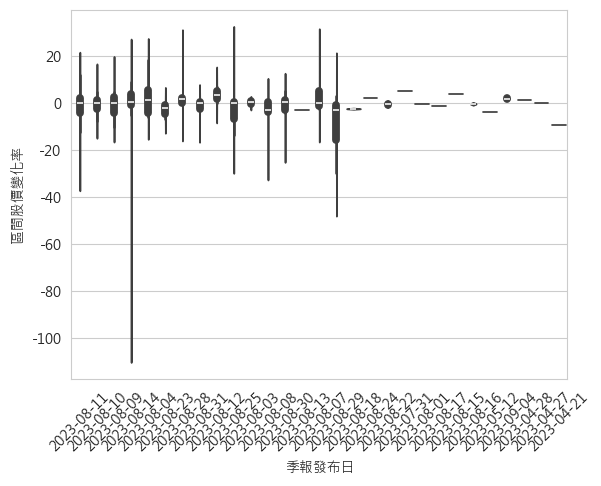

<Figure size 640x480 with 0 Axes>

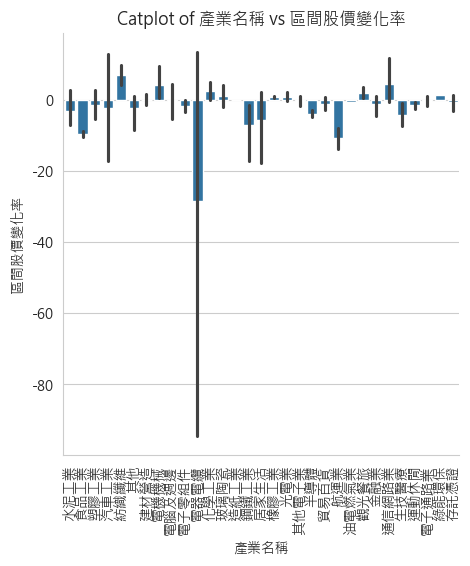

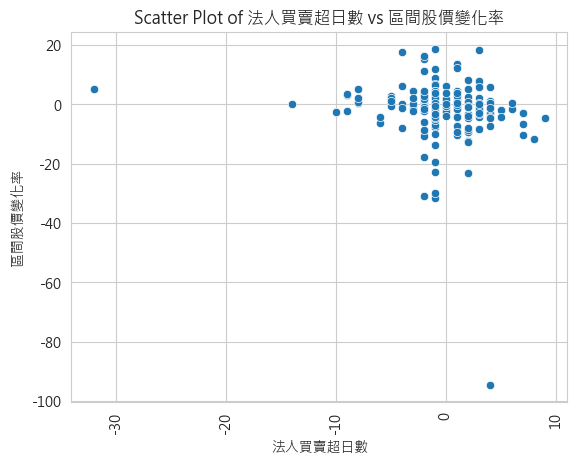

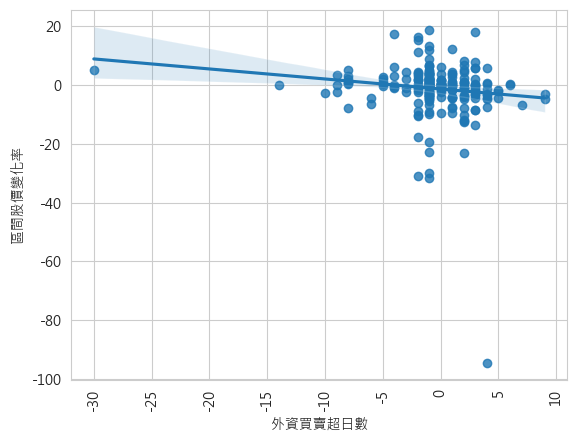

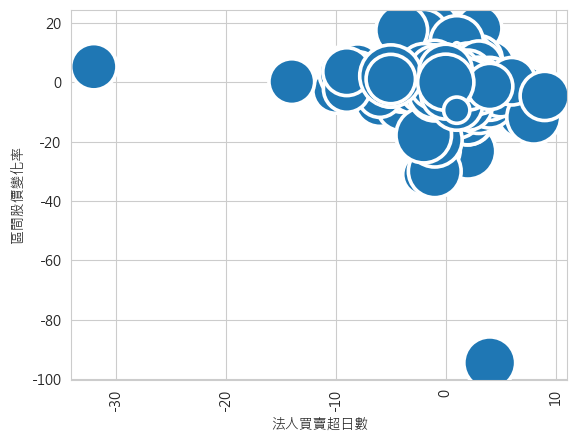

combinations_list
[('產業名稱', '法人買賣超日數', 'ROA(C)稅前息前折舊前'), ('產業名稱', '法人買賣超日數', '外資買賣超日數'), ('產業名稱', '法人買賣超日數', '季報發布日'), ('產業名稱', 'ROA(C)稅前息前折舊前', '外資買賣超日數'), ('產業名稱', 'ROA(C)稅前息前折舊前', '季報發布日'), ('產業名稱', '外資買賣超日數', '季報發布日'), ('法人買賣超日數', 'ROA(C)稅前息前折舊前', '外資買賣超日數'), ('法人買賣超日數', 'ROA(C)稅前息前折舊前', '季報發布日'), ('法人買賣超日數', '外資買賣超日數', '季報發布日'), ('ROA(C)稅前息前折舊前', '外資買賣超日數', '季報發布日')]


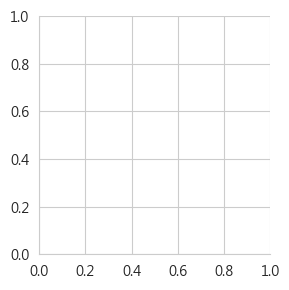

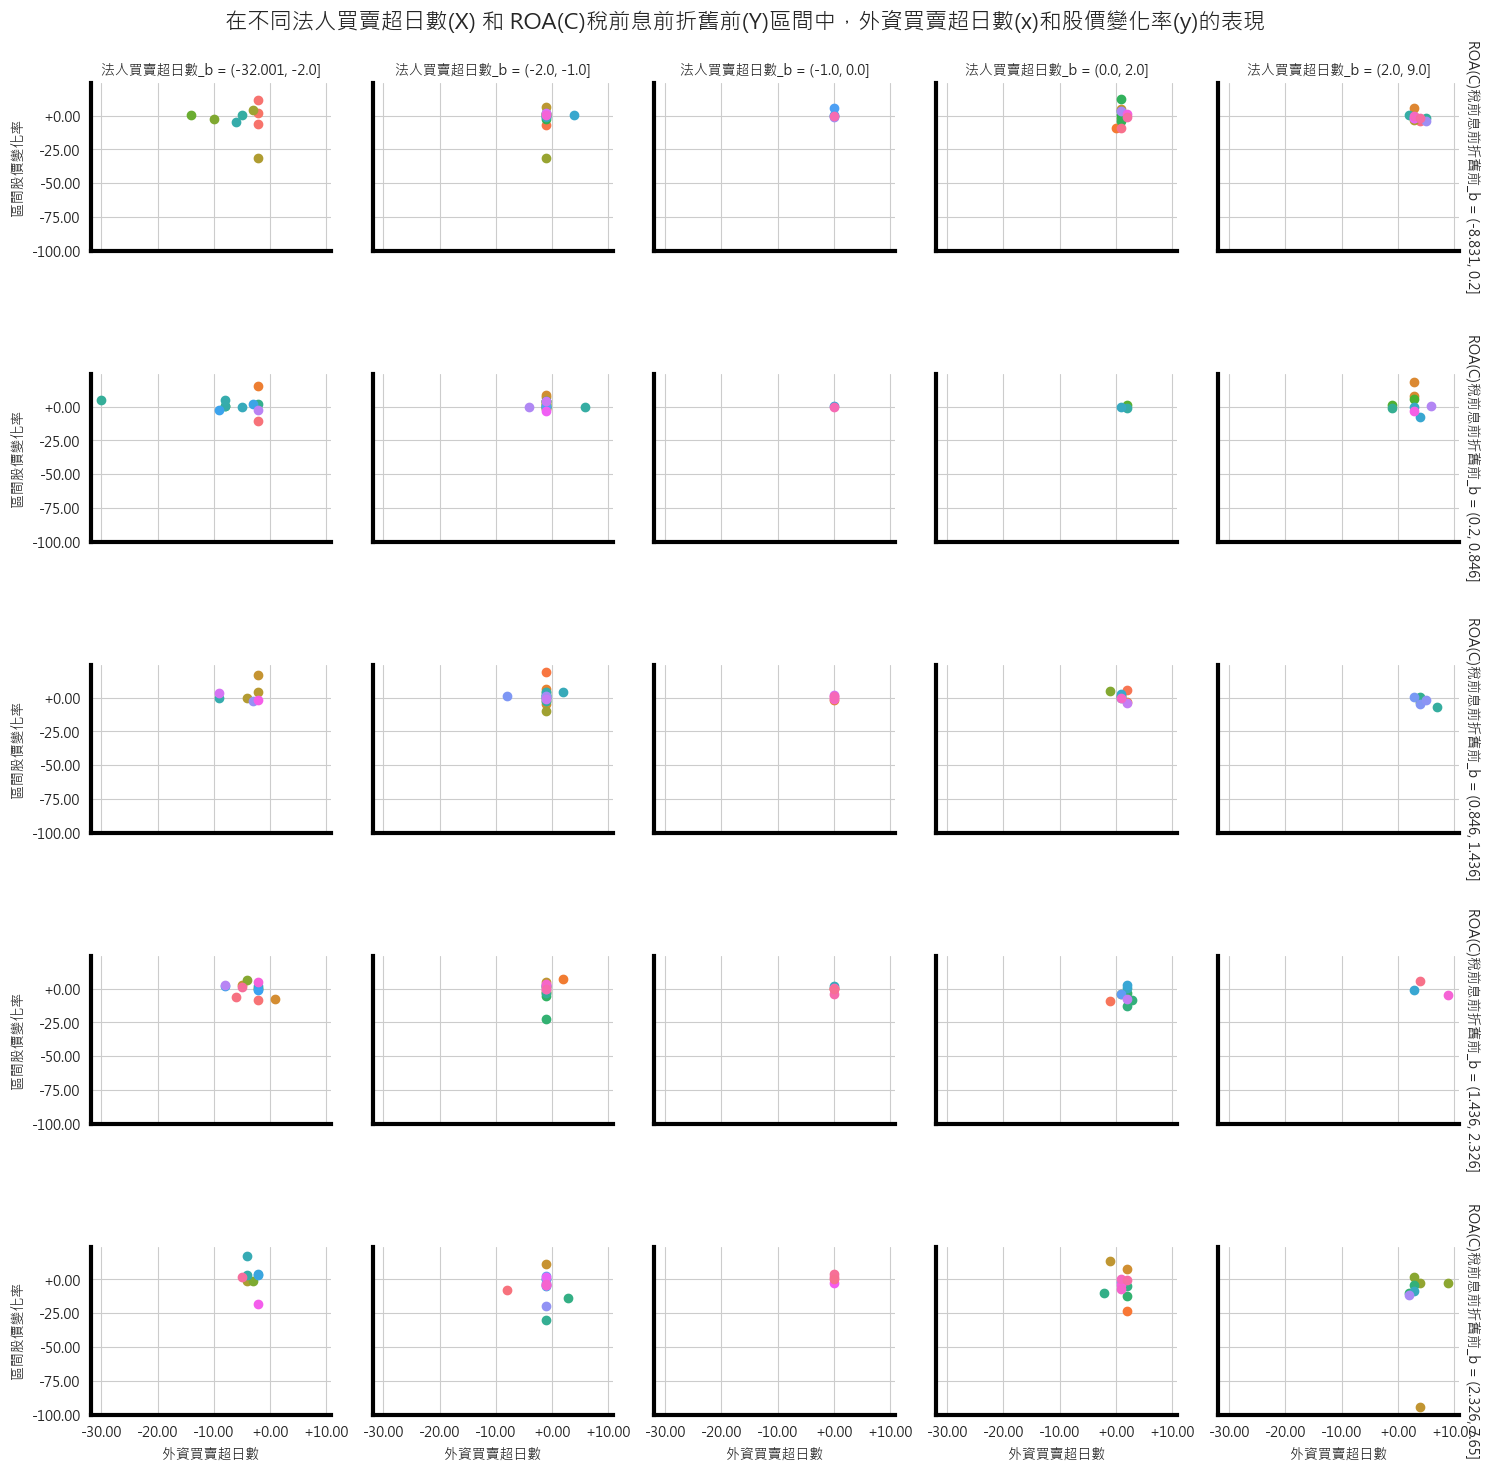

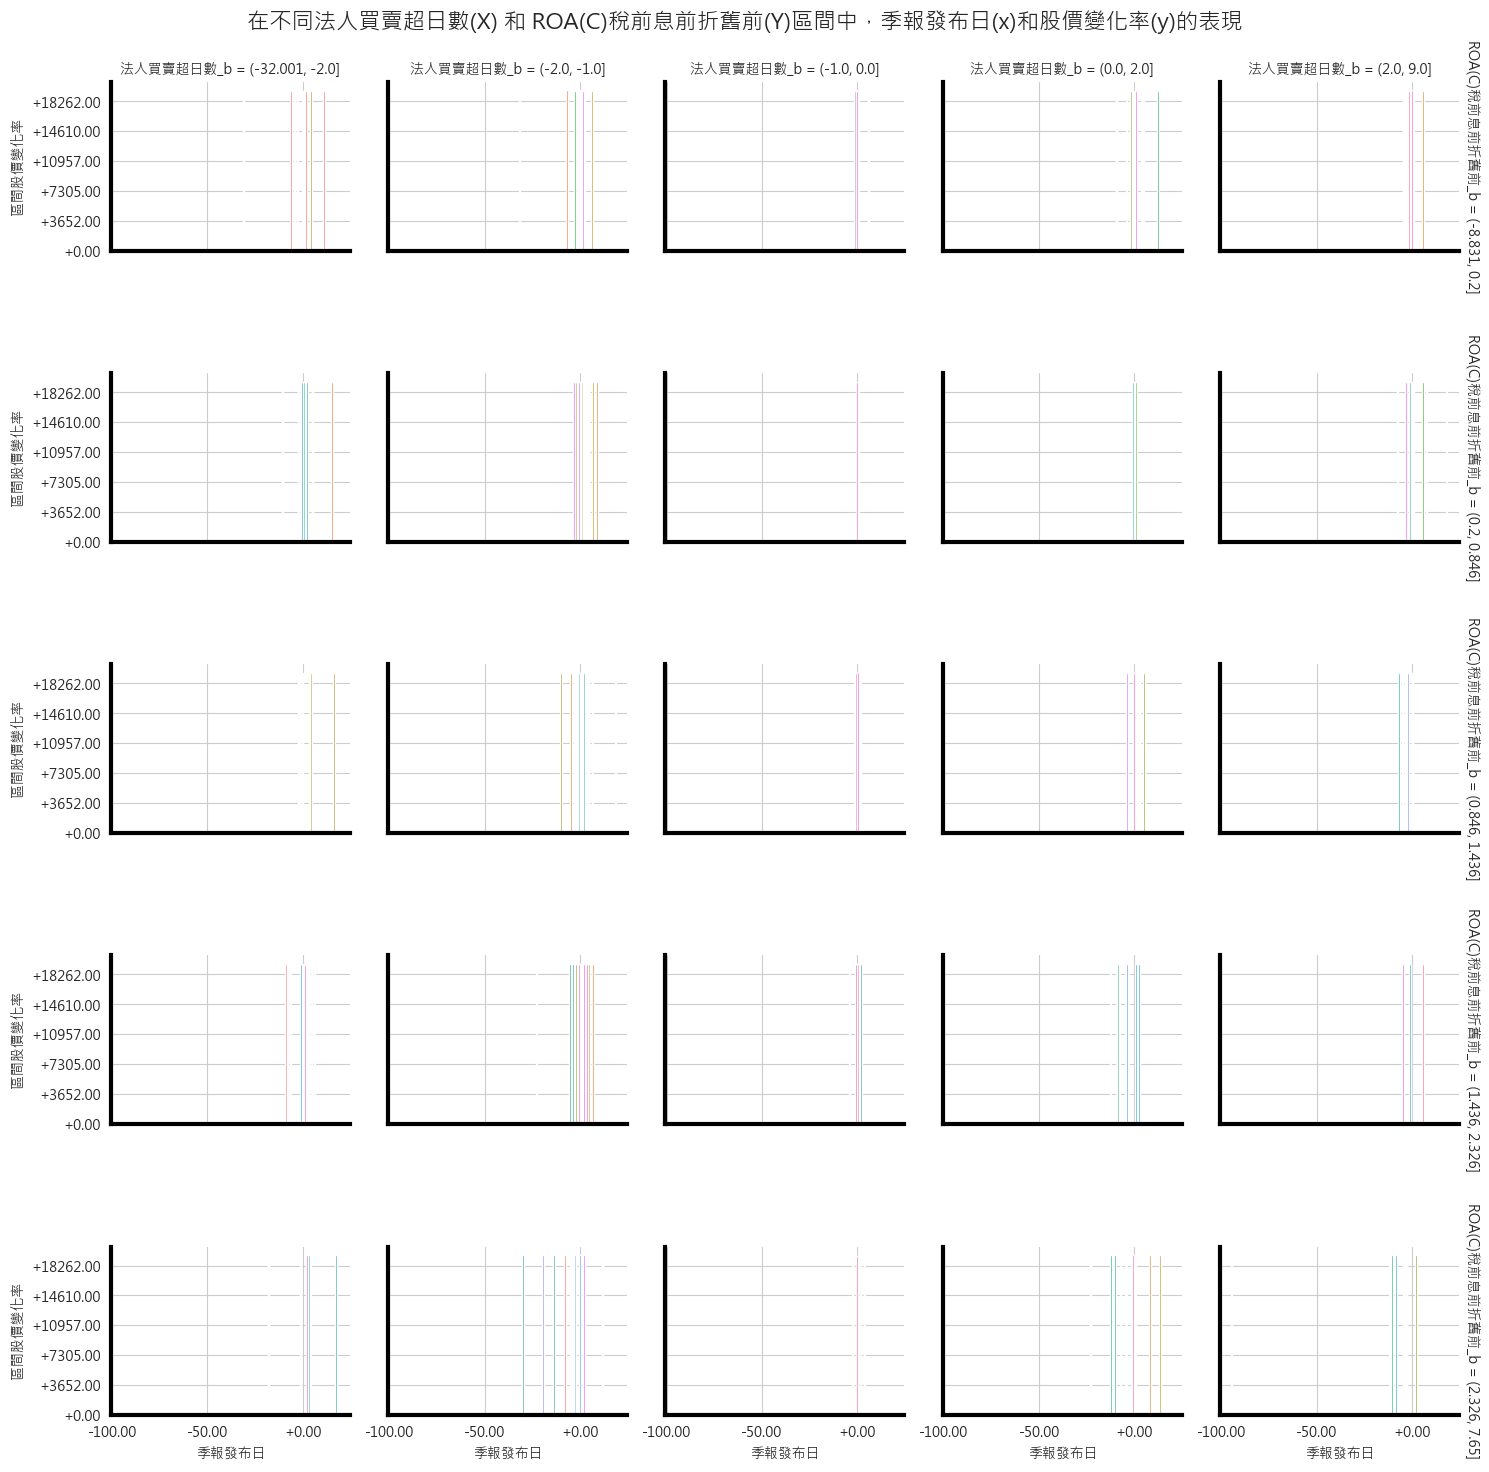

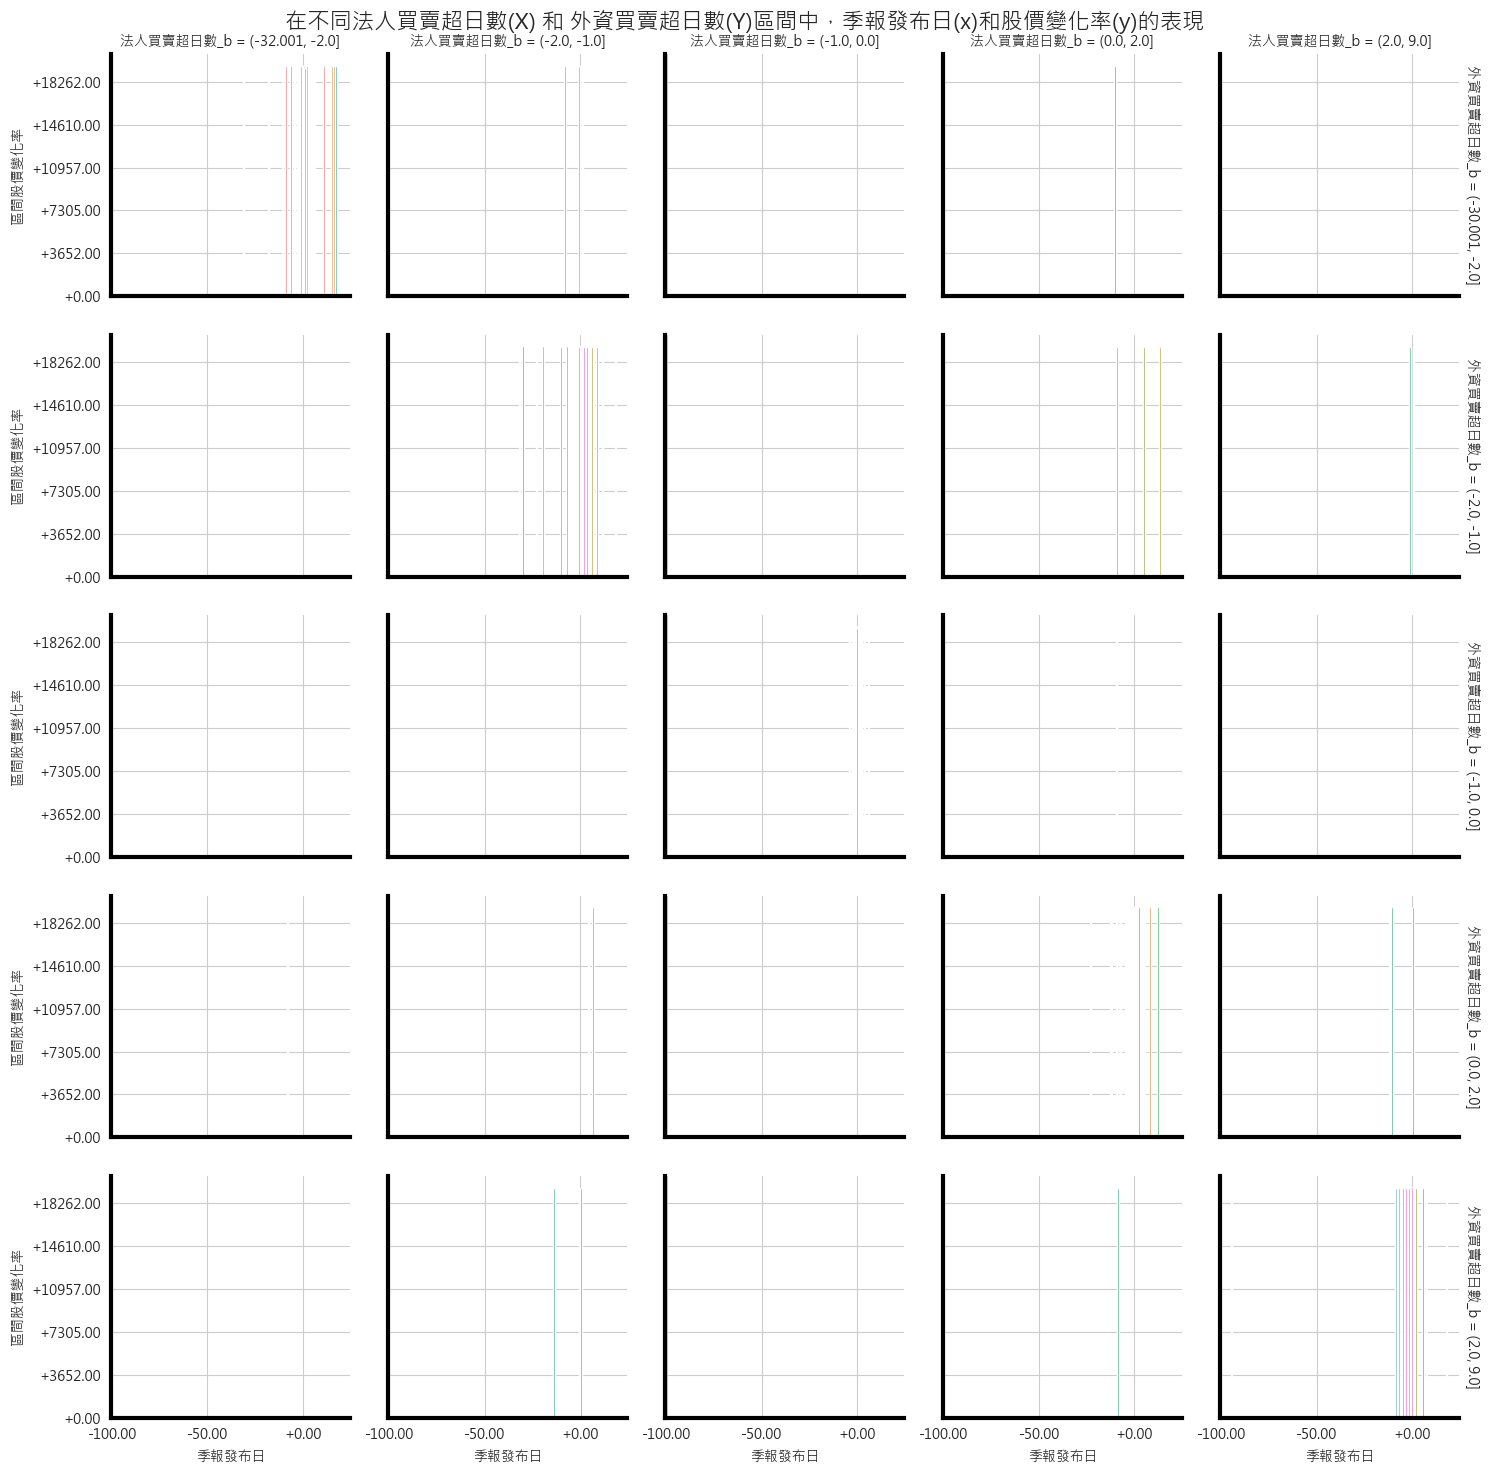

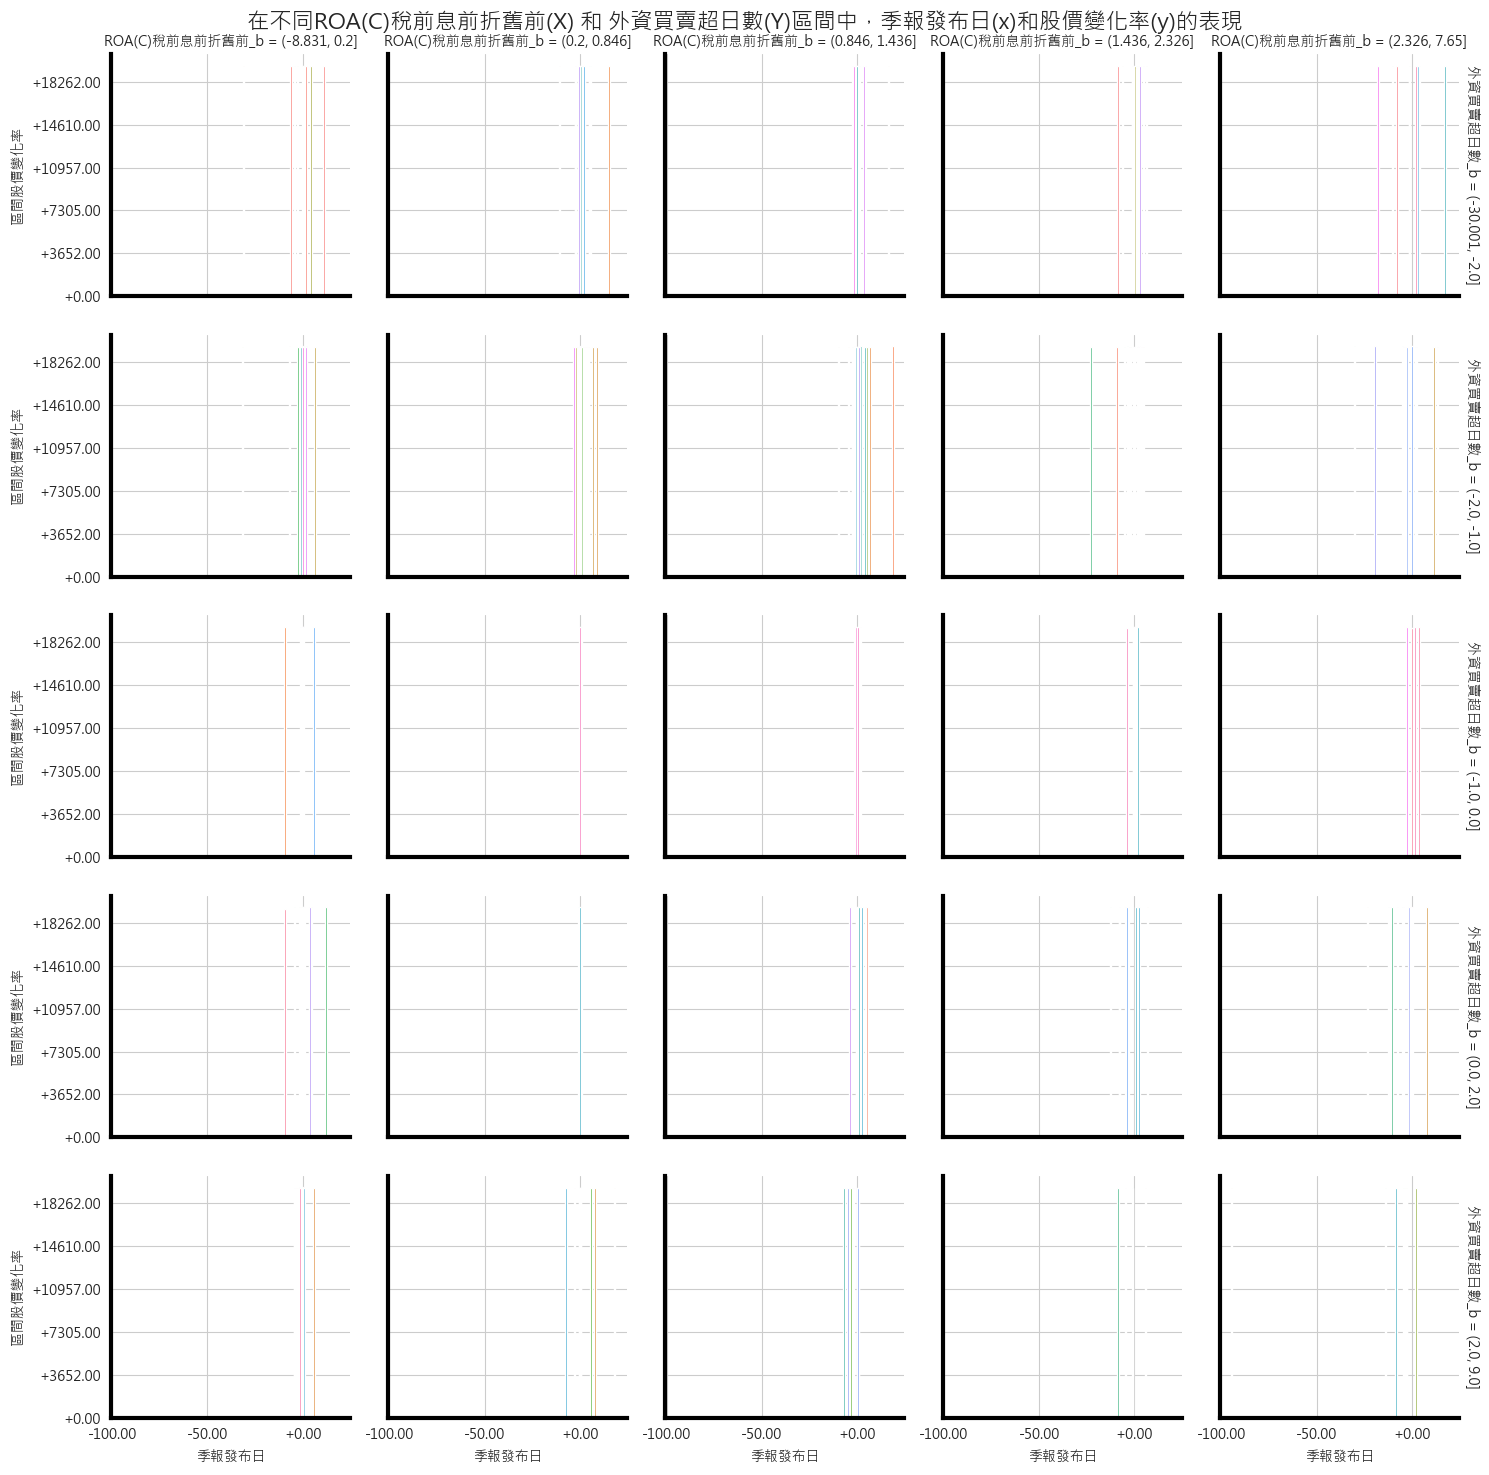

所有圖表已保存到 output_plots.pdf


In [6]:
F_Draw(filtered_data,features)